## Switching Linear Dynamical Systems fMRI Demo

Fit an SLDS From Data
SSM provides the capability to learn the parameters of an SLDS from data. In the above cells, we sampled from 100 time-steps in order to visualize the state trajectory.

In order to learn an SLDS, we'll need more data, so we start by sampling for a longer period. In the following cells, we'll treat our observations as a dataset, and demonstrate how to learn an SLDS using SSM.

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

import scipy.io

In [2]:
# Import fMRI data
mat = scipy.io.loadmat('data/logan_tmsPredict_aug2019.mat')
data = mat['logan_timeSeries_roi25']
data = data[:,:,:1] # Comment out

In [3]:
data.shape

(298, 25, 1)

In [4]:
# Set the parameters of the SLDS
time_bins = data.shape[0]    # number of time bins
n_disc_states = 5       # number of discrete states
latent_dim = 2       # number of latent dimensions
emissions_dim = data.shape[1]      # number of observed dimensions
n_scans = data.shape[2]

cmap_limited = ListedColormap(colors[0:n_disc_states])

**Fit using Laplace-EM**

In [5]:
states=[]

for i in range(n_scans):
    print("Fitting SLDS with Laplace-EM")

    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(data[:,:,i], method="laplace_em",
                                   variational_posterior="structured_meanfield",
                                   num_iters=25, alpha=0.0)

    # Get the posterior mean of the continuous states
    q_lem_x = q_lem.mean_continuous_states[0]

    # Find most likely states
    q_lem_z = slds.most_likely_states(q_lem_x, data[:,:,i])

    # Smooth the data under the variational posterior
    q_lem_y = slds.smooth(q_lem_x, data[:,:,i])
    
    states.append(q_lem_z)

Fitting SLDS with Laplace-EM


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

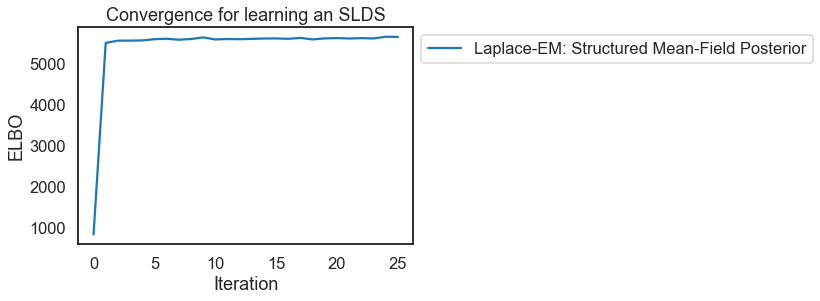

In [6]:
# Plot the ELBOs
plt.plot(q_lem_elbos, label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an SLDS")
plt.show()

# Visualize Inferred Latent States

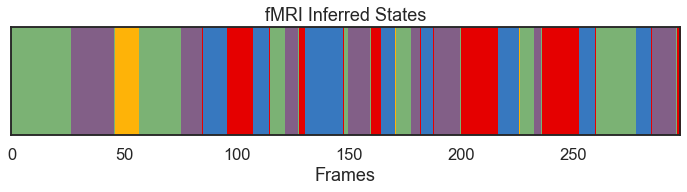

In [7]:

for i in range(n_scans):
    plt.figure(figsize=(12,2))
    plt.imshow(states[i][None,:], aspect='auto', cmap=cmap_limited)
    plt.title('fMRI Inferred States')
    plt.xlabel('Frames')
    ax = plt.gca()
    ax.set_yticks([])
    plt.savefig('scan_%i' % (i))
    plt.show()

# Inference on unseen data
After learning a model from data, a common use-case is to compute the distribution over latent states given some new observations. For example, in the case of a simple LDS, we could use the Kalman Smoother to estimate the latent state trajectory given a set of observations. 

In the case of an SLDS (or Recurrent SLDS), the posterior over latent states can't be computed exactly. Instead, we need to live with a variational approximation to the true posterior. SSM allows us to compute this approximation using the `SLDS.approximate_posterior()` method. 

In the below example, we generate some new data from the true model. We then use the `approximate_posterior()` function to estimate the continuous and discrete states. 

  0%|          | 0/50 [00:00<?, ?it/s]

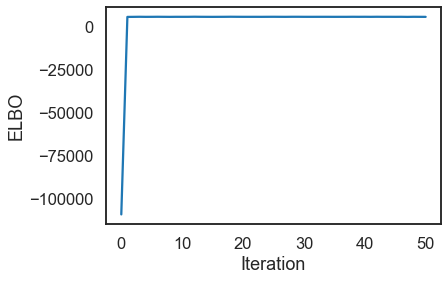

In [8]:
# Use data that was not used for fitting
# Or cheat and do it anyway for practice ;)
validation = data[:,:,0]

# Compute the approximate posterior over latent and continuous
# states for the new data under the current model parameters.
elbos, posterior = slds.approximate_posterior(validation,
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=50)

# Verify that the ELBO increases during fitting. We don't expect a substantial increase:
# we are updating the estimate of the latent states but we are not changing model params.
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

**Estimating Latent States**  
  
`posterior` is now an `ssm.variational.SLDSStructuredMeanFieldVariationalPosterior` object. Using this object, we can estimate the continuous and discrete states just like we did after calling the fit function.

In the below cell, we get the estimated continuous states as follows:
```python
posterior_x = posterior.mean_continuous_states[0]
```
This line uses the `mean_continuous_states` property of the posterior object, which returns a list, where each entry of the list corresponds to a single trial of data. Since we have only passed in a single trial the list will have length 1, and we take the first entry.

We then permute the discrete and continuous states to best match the ground truth. This is for aesthetic purposes when plotting. The following lines compute the best permutation which match the predicted states (`most_likely`) to the ground truth discrete states (`data_z`). We then permute the states of the SLDS accordingly:
```python

most_likely = slds.most_likely_states(posterior_x, data)
perm = find_permutation(data_z, most_likely)
slds.permute(perm)
z_est = slds.most_likely_states(posterior_x, data)

```

In [9]:
x_est = posterior.mean_continuous_states[0]
z_est = slds.most_likely_states(x_est, validation)

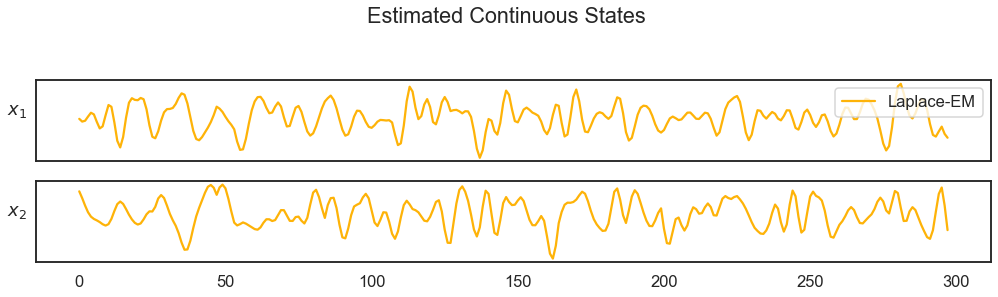

In [10]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(x_est[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("Estimated Continuous States", va="bottom")
plt.tight_layout()

In [61]:
model_z, model_x, model_y = slds.sample(time_bins)

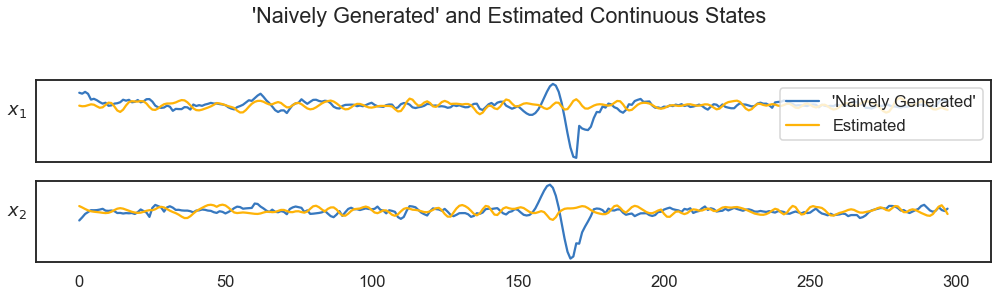

In [62]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(model_x[:,d] + 4 * d, '-', color=colors[0], label="'Naively Generated'" if d==0 else None)
    ax.plot(x_est[:,d] + 4 * d, '-', color=colors[2], label="Estimated" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle(" 'Naively Generated' and Estimated Continuous States", va="bottom")
plt.tight_layout()

In [143]:
A = slds.dynamics.As
b = slds.dynamics.bs
cov = slds.dynamics.Sigmas
n_gen = 1000

mse = np.zeros(n_gen)
mae = np.zeros(n_gen)

for j in range(n_gen):
    x = [x_est[0]]
    
    for i in range(time_bins-1):
        k = z_est[i]
        w = np.random.multivariate_normal(np.zeros(latent_dim), cov[k])
        x_i = A[k]@x[-1] + b[k] + w
        x.append(x_i)
    
    x_gen = np.vstack(x)
    mse[j] = np.mean((x_est - x_gen)**2)
    mae[j] = np.mean(np.abs(x_est - x_gen))

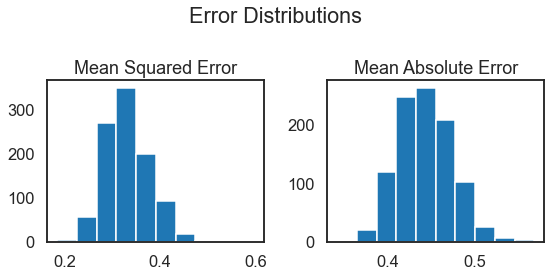

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(mse)
axs[0].set_title('Mean Squared Error')
axs[1].hist(mae)
axs[1].set_title('Mean Absolute Error')

plt.suptitle("Error Distributions")
plt.tight_layout()

TypeError: only size-1 arrays can be converted to Python scalars

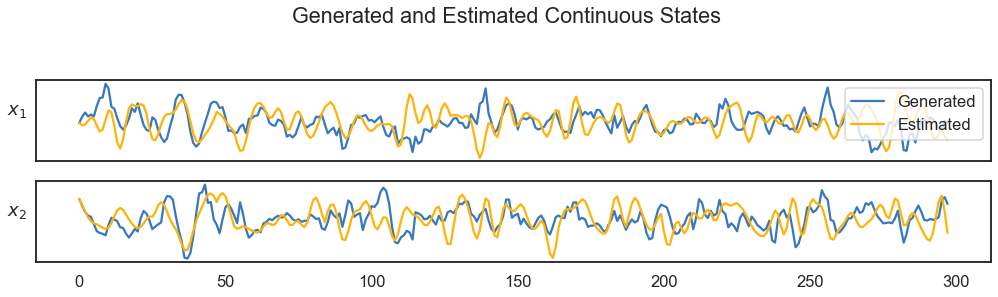

In [133]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(x_gen[:,d] + 4 * d, '-', color=colors[0], label="Generated" if d==0 else None)
    ax.plot(x_est[:,d] + 4 * d, '-', color=colors[2], label="Estimated" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("Generated and Estimated Continuous States", va="bottom")
plt.tight_layout()

print('mse = %f'  %mse)
print('mae = %f'  %mae)